# Deps

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
txt_proc = [TokenizeProcessor(tokenizer=Tokenizer(lang='el') ),NumericalizeProcessor()]

In [4]:
def SampleTexts(df,max_tokens = 100000000):
    lens = np.array(df.apply(lambda x : len(re.findall(r'\b',x.text))/2,axis=1))
    n_tokens = np.sum(lens)
    if n_tokens <= max_tokens:
        return range(0,df.shape[0]), n_tokens
    #if np.sum(lens) > max_tokens:
    iDec = (-lens).argsort()
    cumSum = np.cumsum(lens[iDec])
    iCut = np.argmax(cumSum>max_tokens)
    return iDec[:iCut], cumSum[iCut-1]

# Greek Lanuage Model

Extract the data from wikipedia using <a href="https://forums.fast.ai/t/language-model-zoo-gorilla/14623/19">this guide</a> by Moody.

In [5]:
path_root = Path('/home/jupyter/tutorials/')
source_txt = 'el_wiki_df_all.csv'
bs = 112

## Preparing the data

The wiki text is contained in lots of seperate json files, so first we combine into a single large csv which we load with the data loader.
We don't want to train with more than 100,000,000 tokens.  For the Greek corpus this is not a problem becuase there are much less than this number of tokens available.
To sample we can reduce this number of tokens even futher is desired.

In [6]:
df = []
for file in path_lang_model.glob("el_dump/*/*"):
    df_file = pd.read_json(file,lines=True,encoding="utf-8")
    df.append(df_file)
df = pd.concat(df, axis=0)

In [7]:
df.to_csv(path_lang_model/wiki_103_csv,index=False)

In [8]:
df = pd.read_csv(path_lang_model/wiki_103_csv)

In [9]:
max_tokens = 100000000
i_keep,n_tokens = SampleTexts(df,max_tokens)

In [10]:
if len(i_keep) == df.shape[0]:
    print(f'{n_tokens} tokens < {max_tokens}, no need to sample')
else:
    df_sample = df.iloc[i_keep]
    df_sample.to_csv(path_lang_model/f'../el_wiki_df_{n_tokens}.csv',index=False)

57956630.0 tokens < 100000000, no need to sample


## Try small sample

### Sample

In [6]:
df = pd.read_csv(path_root/'data'/wiki_103_csv)
max_tokens = 1000000

In [8]:
i_keep,n_tokens = SampleTexts(df,max_tokens)
df_sample = df.iloc[i_keep]
df_sample.to_csv(path_root/f'data/el_wiki_df_{n_tokens}.csv',index=False)

### Tokenize for language model

Initially limit the vocab to 30k to compare with other ULMFit methods

In [9]:
source_txt = f'el_wiki_df_{n_tokens}.csv'
max_vocab = 30000

In [10]:
data_lm = (TextList.from_csv(path_root,f'data/{source_txt}',cols=1,
    processor = [TokenizeProcessor(tokenizer=Tokenizer(lang='el')) , NumericalizeProcessor(vocab=None, max_vocab=max_vocab)])
    .random_split_by_pct(0.1)
    .label_for_lm()
    .databunch(bs=bs))
print(f'Vocab size: {len(data_lm.vocab.itos)}')

Vocab size: 26952


In [12]:
data_lm.save('tmp_data_'+ source_txt)

### Fit

In [13]:
data_lm = TextLMDataBunch.load(path_root, 'tmp_data_'+ source_txt ,bs=bs)

In [14]:
learn = language_model_learner(data_lm, drop_mult=0.3)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


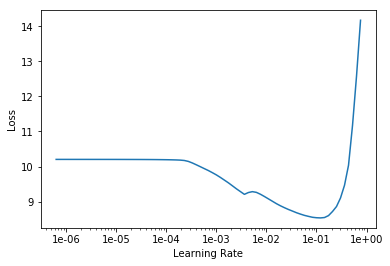

In [16]:
learn.recorder.plot(skip_end=10)

epoch,train_loss,valid_loss,accuracy
1,5.173456,5.126557,0.228841
2,4.329980,4.624084,0.250723
3,4.067498,4.527374,0.249065
4,3.807165,4.503901,0.256498
5,3.655459,4.417594,0.262571
6,3.393641,4.397531,0.265703
7,3.204198,4.403481,0.267623
8,2.878831,4.440259,0.265653
9,2.656471,4.477993,0.265583
10,2.515639,4.506126,0.263556


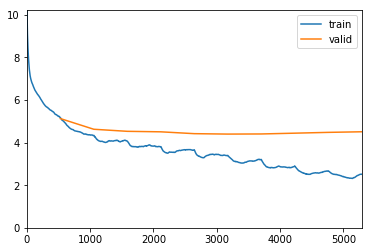

In [17]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max')])

## Process full text

### Tokenize for language model

Initially limit the vocab to 30k to compare with other ULMFit methods

In [6]:
#source_txt = wiki_103_csv
max_vocab = 30000

In [19]:
data_lm = (TextList.from_csv(path_root,f'data/{source_txt}',cols=1,
    processor = [TokenizeProcessor(), NumericalizeProcessor(vocab=None, max_vocab=max_vocab)])
    .random_split_by_pct(0.1)
    .label_for_lm()
    .databunch(bs=bs))
print(f'Vocab size: {len(data_lm.vocab.itos)}')
data_lm.save('tmp_data_lm'+ source_txt)

Vocab size: 30004


In [20]:
#save the dictionary
pickle_out = open(str(path_root/'data/dict_')+ source_txt + '.pkl',"wb")
pickle.dump(data_lm.vocab.itos, pickle_out)
pickle_out.close()

### Fit

In [6]:
data_lm = TextLMDataBunch.load(path_root, 'tmp_data_lm'+ source_txt ,bs=bs)

In [7]:
learn = language_model_learner(data_lm, drop_mult=0.1)

In [8]:
learn.load('bestmodel_lm4_' + source_txt);

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


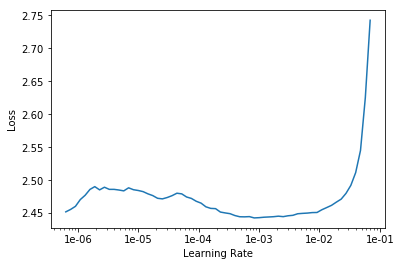

In [11]:
learn.recorder.plot(skip_end=20)

epoch,train_loss,valid_loss,accuracy
1,2.420447,2.678280,0.444547
2,2.438366,2.678463,0.444549
3,2.448281,2.678690,0.444479
4,2.446615,2.679159,0.444490
5,2.448099,2.679768,0.444436
6,2.448925,2.680323,0.444430
7,2.484817,2.681858,0.444281
8,2.468067,2.682364,0.444093
9,2.446675,2.683275,0.444169
10,2.444866,2.683297,0.444081


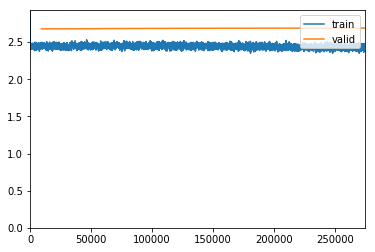

In [12]:
learn.fit_one_cycle(30, 1e-4, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max',name='bestmodel_lm5_' + source_txt)])

epoch,train_loss,valid_loss,accuracy
1,3.516630,3.502415,0.368488
2,3.108189,3.146007,0.393373
3,2.960916,3.014083,0.403630
4,2.907065,2.963251,0.407418
5,2.938919,2.954048,0.407728
6,2.932621,2.956811,0.407428
7,2.899244,2.953241,0.407625
8,2.917248,2.948196,0.408621
9,2.892850,2.934637,0.410076
10,2.851765,2.915483,0.412747


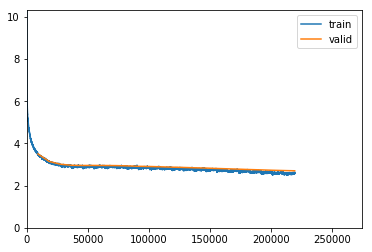

In [ ]:
learn.fit_one_cycle(30, 5e-3, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max',name='bestmodel_lm4_' + source_txt)])

epoch,train_loss,valid_loss,accuracy
1,2.644179,2.757902,0.433078
2,2.611104,2.742862,0.434803
3,2.659393,2.735142,0.435706
4,2.600873,2.733883,0.435902
5,2.661493,2.734544,0.435991
6,2.598961,2.735075,0.436015
7,2.691365,2.735578,0.435958
8,2.628348,2.733740,0.436121
9,2.602951,2.732482,0.436326
10,2.618928,2.729969,0.436860


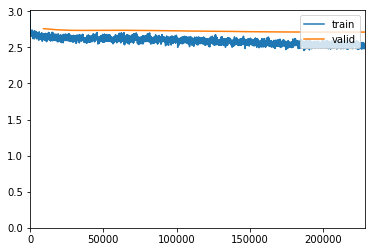

In [11]:
learn.fit_one_cycle(25, 5e-4, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max',name='bestmodel_lm3_' + source_txt)])

epoch,train_loss,valid_loss,accuracy
1,3.321554,3.344877,0.381419
2,3.056772,3.130726,0.396556
3,3.081648,3.100961,0.398909
4,3.071982,3.109213,0.396979
5,3.080972,3.136237,0.393375
6,3.083397,3.145629,0.392689
7,3.083289,3.144316,0.392856
8,3.031167,3.130823,0.394640
9,3.064320,3.117794,0.395464
10,3.003952,3.098934,0.397990


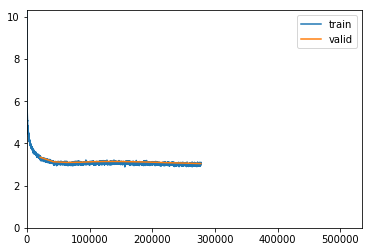

In [ ]:
learn.fit_one_cycle(25, 6e-3, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max',name='bestmodel_lm1_' + source_txt)])

epoch,train_loss,valid_loss,accuracy
1,3.350695,3.349565,0.379826
2,3.075884,3.105903,0.396633
3,3.005885,3.052592,0.400517
4,3.015425,3.062472,0.399372
5,3.029361,3.076485,0.397883
6,3.045590,3.081234,0.397158
7,3.032195,3.082323,0.397342
8,2.997538,3.062957,0.398935
9,3.033343,3.046785,0.400325
10,3.025974,3.031545,0.402599


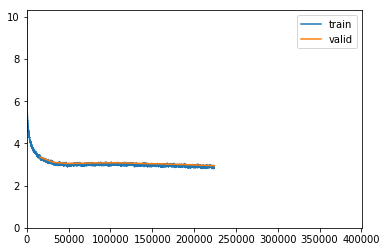

In [ ]:
learn.fit_one_cycle(25, 6e-3, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max',name='bestmodel_lm_' + source_txt)])

In [10]:
#learn = language_model_learner(data_lm, drop_mult=0.1)
learn = language_model_learner(data_lm, drop_mult=0.1,qrnn=True)

FileNotFoundError: [Errno 2] No such file or directory: '/opt/anaconda3/lib/python3.7/site-packages/fastai/text/qrnn/forget_mult_cuda.cpp'